In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from MERFISH_probe_design.probe_design import filters

# Compare different methods for Tm calculation

In [2]:
# Randomly generate sequences
bases = ['A', 'T', 'C', 'G']

sequences = []
for i in range(10000):
    sequences.append(''.join(np.random.choice(bases, 30)))
    
# Wrap the sequences into a probe dictionary
probe_dict = {'g':{'t':pd.DataFrame({'target_sequence':sequences})}}
probe_dict['g']['t']

,target_sequence
0,GCGCTATCGTATGGACGGTCACGGCGAGCT
1,TAGTTTCTAGAGCACCGCCTGTCAATATAC
2,TGGGATGCCGGAGATTAGATCGAATGCGAG
3,AATATGCCTACTATTCTATTTGGGTGCCTC
4,AAAAAGTGGTCATATCGCATAAGATCCCAA
...,...
9995,TATGCATAATTGAATCAGAGTTGCCAAAGT
9996,GTCCTCACGGAACCTGAACACTGTAATTTA
9997,CGTGCTTGAAGTTTCTGTCGTCTTTCTGAA
9998,ATGCTGACGGAAGTACTGAGTTATTGTGTG


In [3]:
# Calculate Tm by Jeff Moffitt's method
filters.calc_tm_JM_for_probe_dict(probe_dict, monovalentSalt=0.3, probe_conc=5e-9,
                              column_key_seq='target_sequence', column_key_write='target_Tm_JM')

In [4]:
# Calculate Tm by the biopython method  
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=300, fmd_percentile=0, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm_Bio')

In [5]:
# Calculate Tm by the new method and consider the formamide
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=300, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm_Bio_fmd')

In [6]:
# Calculate Tm by the new method and consider the formamide and actual concentrations of each probe
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=300, fmd_percentile=30, probe_conc=0.05,
                              column_key_seq='target_sequence', column_key_write='target_Tm_Bio_fmd_conc')

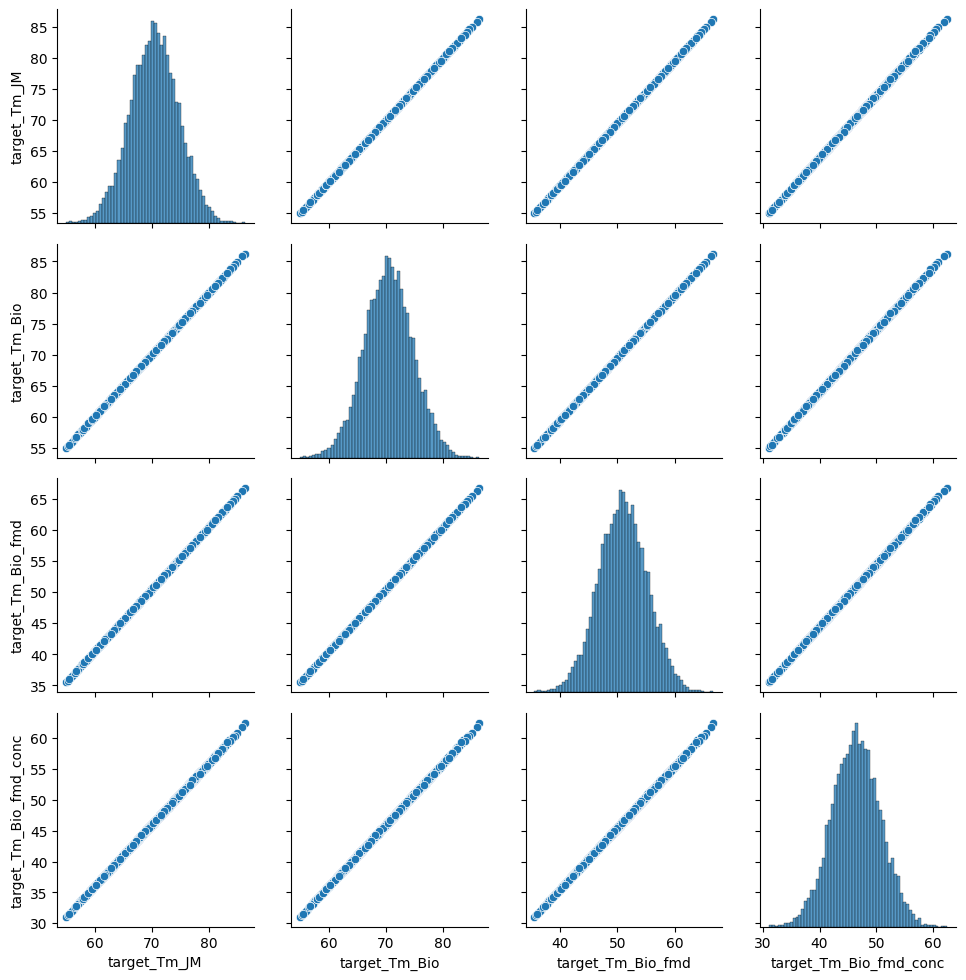

In [7]:
# Plot the correlations between different methods/paramters
g = sns.PairGrid(probe_dict['g']['t'])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

<Axes: ylabel='Density'>

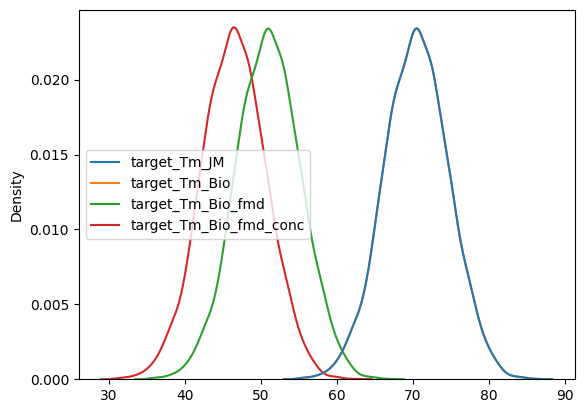

In [8]:
# Plot the distributions of Tms
sns.kdeplot(data=probe_dict['g']['t'])

In [9]:
# Print the means
print(f"target_Tm_JM: {np.mean(probe_dict['g']['t']['target_Tm_JM']):.2f} °C")
print(f"target_Tm_Bio: {np.mean(probe_dict['g']['t']['target_Tm_Bio']):.2f} °C")
print(f"target_Tm_Bio_fmd: {np.mean(probe_dict['g']['t']['target_Tm_Bio_fmd']):.2f} °C")
print(f"target_Tm_Bio_fmd_conc: {np.mean(probe_dict['g']['t']['target_Tm_Bio_fmd_conc']):.2f} °C")

target_Tm_JM: 70.47 °C
target_Tm_Bio: 70.47 °C
target_Tm_Bio_fmd: 50.97 °C
target_Tm_Bio_fmd_conc: 46.46 °C


# Test effects of experimental conditions

In [10]:
from Bio.SeqUtils import MeltingTemp

In [11]:
# Generate random sequences and concentrations
N_seqs = 100000
length_range = [10, 50]
conc_range_log10 = [-3, 3] # In log10 of nM
Na_range = [10, 590]

bases = ['A', 'T', 'C', 'G']
sequences = []
lengths = []
concentrations = []
Na_concentrations = []
for i in range(N_seqs):
    length = np.random.randint(*length_range)
    lengths.append(length)
    sequences.append(''.join(np.random.choice(bases, length)))
    concentrations.append(10 ** np.random.uniform(*conc_range_log10))
    Na_concentrations.append(np.random.uniform(*Na_range))

In [12]:
# Calculate the Tms
tms = []
for i in range(N_seqs):
    tm_raw = MeltingTemp.Tm_NN(sequences[i], nn_table=MeltingTemp.DNA_NN4, Na=Na_concentrations[i], 
                               dnac1=concentrations[i], dnac2= 0)
    tms.append(MeltingTemp.chem_correction(tm_raw, 30))

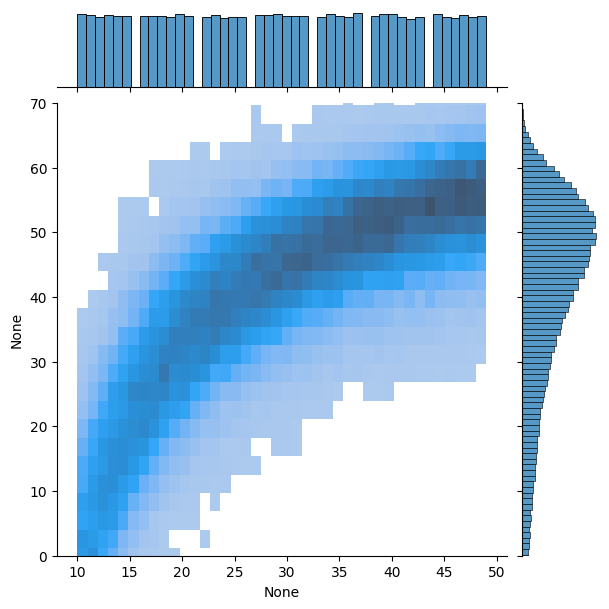

In [13]:
# Plot the effect of probe lengths
sns.jointplot(x=lengths, y=tms, bins=40, ylim=(0, 70), kind='hist')

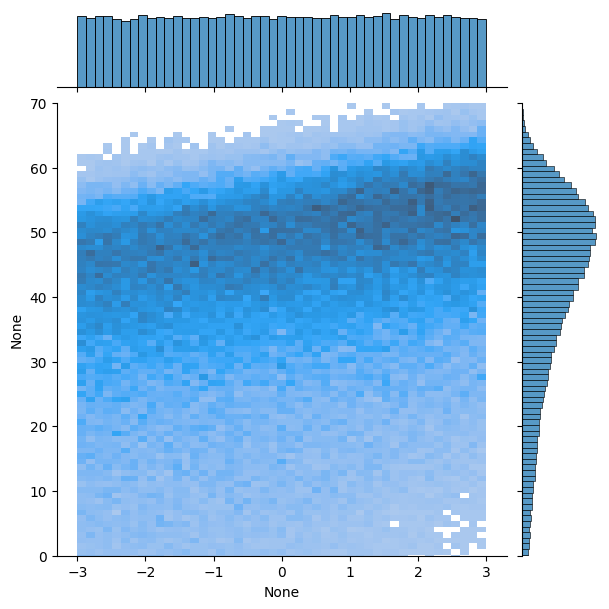

In [14]:
# Plot the effect of probe concetrations
sns.jointplot(x=np.log10(concentrations), y=tms, ylim=(0, 70), kind='hist')

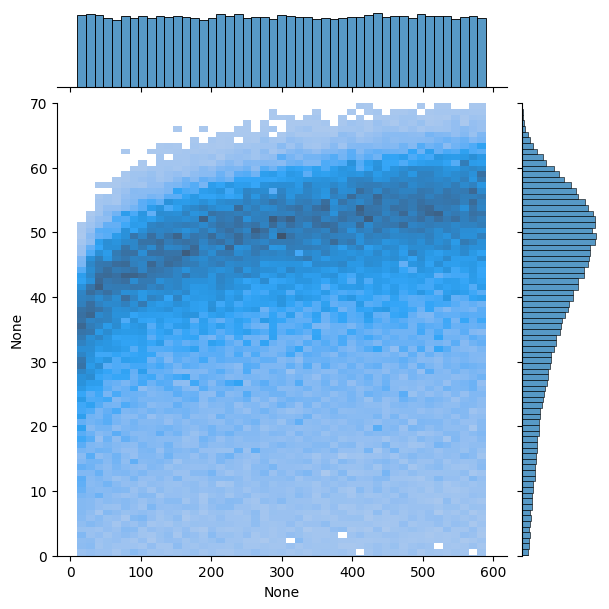

In [15]:
# Plot the effect of Na concetrations
sns.jointplot(x=Na_concentrations, y=tms, ylim=(0, 70), kind='hist')